In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from minisom import MiniSom
import matplotlib.pyplot as plt
# 
# from sklearn.datasets import load_wine
# data = load_wine()
# X = data.data      # Shape: (178, 13)
# y = data.target

from sklearn.datasets import load_digits
data = load_digits()
X = data.data      # Shape: (1797, 64)
y = data.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For plotting
def plot_2d(X_reduced, title, labels=None):
    plt.figure(figsize=(8, 6))
    
    scatter = plt.scatter(
        X_reduced[:, 0], X_reduced[:, 1],
        c=labels,
        cmap='tab10',  # Better for 10 discrete classes
        edgecolor='k',
        s=40
    )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    # Add color legend only if labels are provided
    if labels is not None:
        legend1 = plt.legend(*scatter.legend_elements(),
                             title="Digits", loc="best", bbox_to_anchor=(1, 1))
        plt.gca().add_artist(legend1)
    
    plt.tight_layout()
    plt.show()



[[-1.11022302e-16 -1.82235067e-01 -2.85867579e-01 -2.20369023e-01
   2.51683414e-02  9.49707999e-03  5.24766456e-02  6.26945542e-02
  -3.47084424e-02 -2.45535226e-01 -2.29151226e-01  1.07943658e-01
  -3.62035261e-02 -3.87117751e-02  8.37809348e-02  9.27743564e-02
  -1.66999373e-02 -1.36717753e-01  6.30517046e-02  1.22879854e-01
  -1.48193855e-01  2.34842964e-02  1.71199724e-01  1.04207881e-01
   3.94874727e-03  1.16389229e-01  1.88205549e-01 -6.58585563e-02
  -1.43531880e-01  1.28207292e-01  1.80620716e-01  5.27096027e-02
  -0.00000000e+00  2.38901978e-01  2.35006167e-01  5.09163759e-03
   1.31085209e-02  1.59115890e-01  1.29393769e-01 -0.00000000e+00
   5.55996101e-02  1.87156714e-01  1.53533399e-01  4.68249995e-02
   1.10892403e-01  1.07209297e-01 -1.79269064e-02  2.27301045e-03
   2.88183809e-02 -4.08671474e-02 -1.10270155e-01 -3.18248943e-02
   7.90488262e-02 -6.83217976e-02 -1.21247702e-01 -4.87708195e-02
   1.83645709e-03 -1.60396483e-01 -2.79852681e-01 -1.94448351e-01
  -1.77741

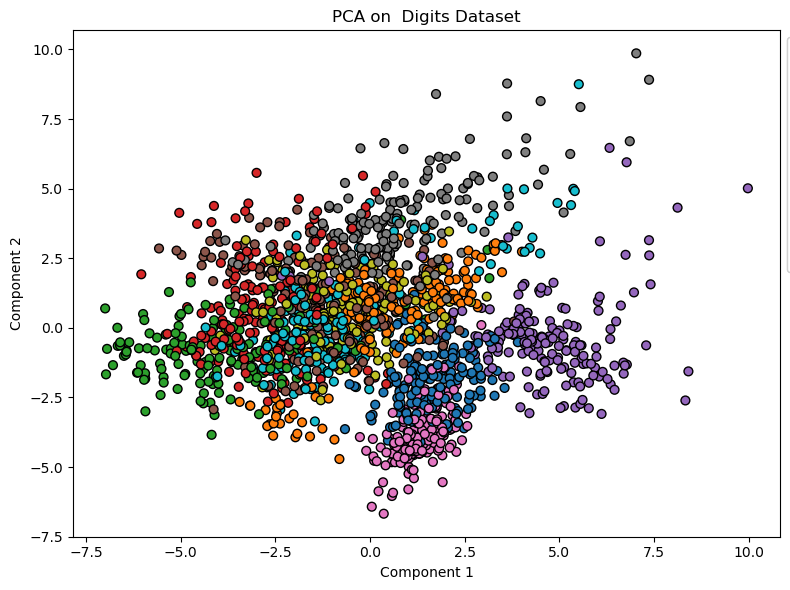

In [2]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(pca.components_)              # The 2 principal directions (each of 13 features)
print(pca.explained_variance_)      # Variance explained by each PC
print(pca.explained_variance_ratio_) # % of variance explained by each PC
print(pca.mean_)                    # Mean of each original feature (for inverse_transform)

plot_2d(X_pca, "PCA on  Digits Dataset",labels=y)

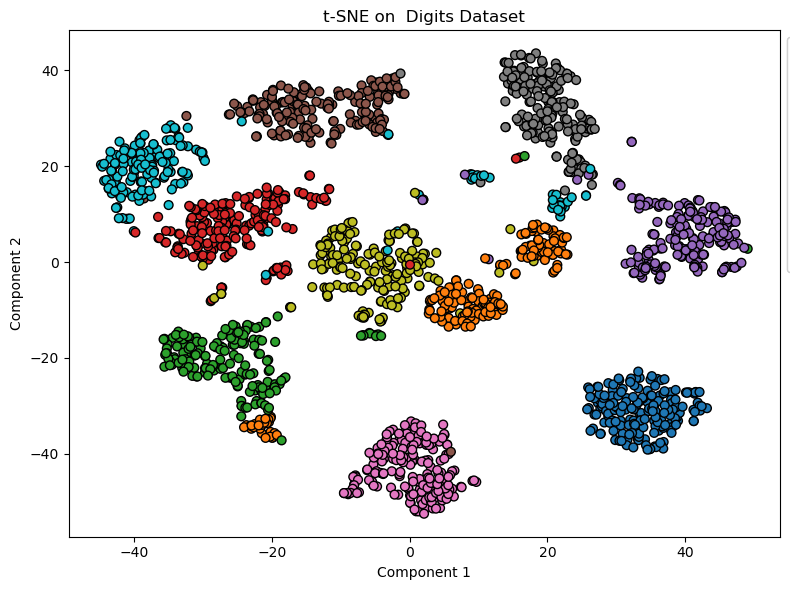

In [3]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
plot_2d(X_tsne, "t-SNE on  Digits Dataset",labels=y)

C:\Users\RTX\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


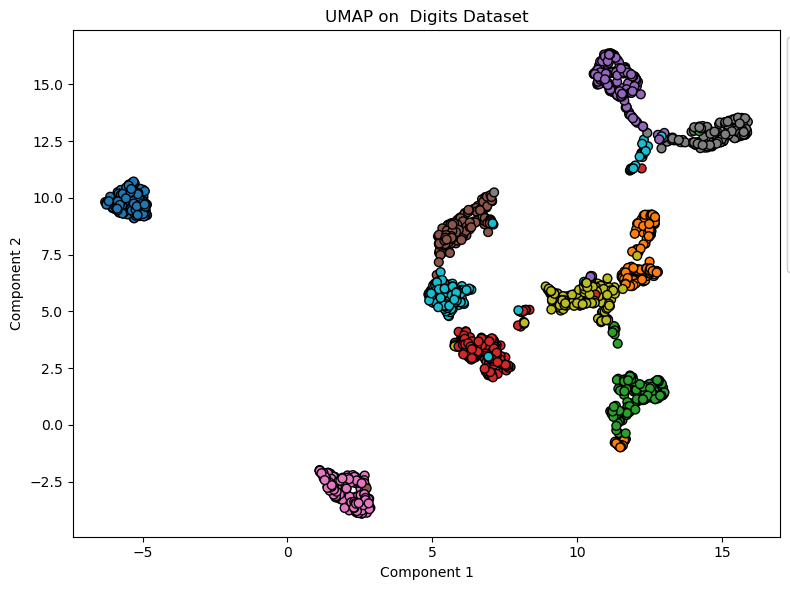

In [4]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
plot_2d(X_umap, "UMAP on  Digits Dataset",labels=y)


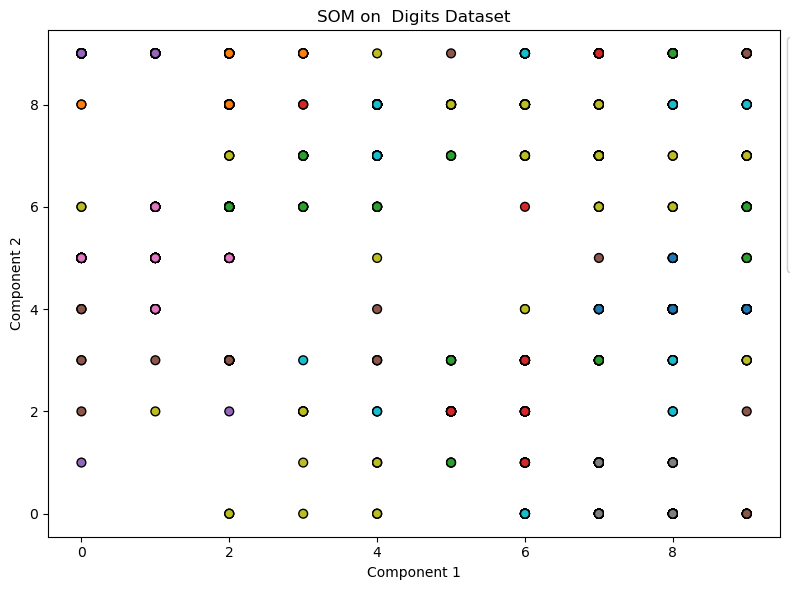

In [5]:
som = MiniSom(x=10, y=10, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(X_scaled, 100)

# Map the input data to the trained SOM
win_map = np.array([som.winner(x) for x in X_scaled])
win_map_2d = np.array(win_map)

plot_2d(win_map_2d, "SOM on  Digits Dataset",labels=y)


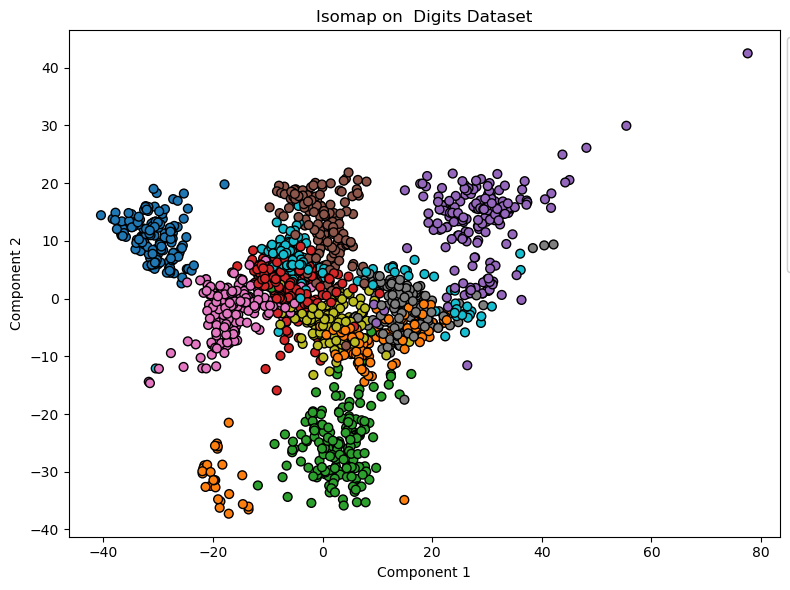

In [6]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)
plot_2d(X_isomap, "Isomap on  Digits Dataset",labels=y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


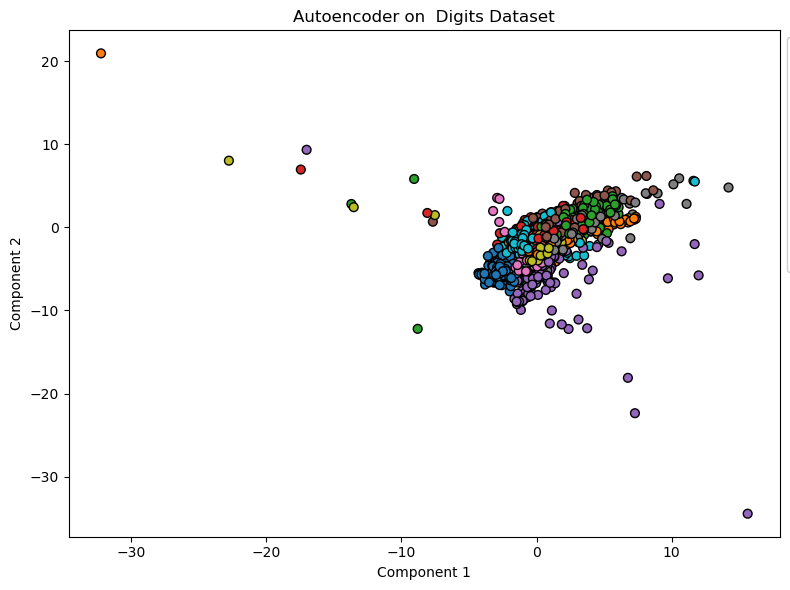

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define simple autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 8  # Reduce to 2 dimensions

input_layer = Input(shape=(input_dim,))
encoded = Dense(20, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='linear')(encoded)

decoded = Dense(20, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=16, verbose=0)

# Encode data
X_encoded = encoder.predict(X_scaled)
plot_2d(X_encoded, "Autoencoder on  Digits Dataset",labels=y)

In [1]:
import time
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, trustworthiness
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, mean_squared_error
import umap
from sklearn.decomposition import PCA
from minisom import MiniSom
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# from sklearn.datasets import load_wine
# data = load_wine()
# X = data.data      # Shape: (178, 13)
# y = data.target

# Load and scale data
digits = load_digits()
X = StandardScaler().fit_transform(digits.data)
y = digits.target

# Store results
results = []

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate(X_reduced, X_original=None, recon=None, name=""):
    start = time.time()

    # Clustering for ARI/NMI/Silhouette
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Classification accuracy using KNN on reduced 2D data
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_reduced, y)
    y_pred = clf.predict(X_reduced)
    accuracy = accuracy_score(y, y_pred)

    end = time.time()

    return {
        "Algorithm": name,
        "ARI": adjusted_rand_score(y, cluster_labels),
        "NMI": normalized_mutual_info_score(y, cluster_labels),
        "Silhouette": silhouette_score(X_reduced, cluster_labels),
        "Trustworthiness": trustworthiness(X, X_reduced, n_neighbors=5),
        "Accuracy (KNN)": accuracy,
        "Time (s)": round(end - start, 3)
    }

# PCA
start = time.time()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_recon = pca.inverse_transform(X_pca)
end = time.time()
results.append(evaluate(X_pca, X, X_pca_recon, "PCA"))

# t-SNE
start = time.time()
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
end = time.time()
results.append(evaluate(X_tsne, name="t-SNE"))

# UMAP
start = time.time()
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
end = time.time()
results.append(evaluate(X_umap, name="UMAP"))

# Isomap
start = time.time()
X_iso = Isomap(n_components=2).fit_transform(X)
end = time.time()
results.append(evaluate(X_iso, name="Isomap"))

# SOM
som = MiniSom(x=10, y=10, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
start = time.time()
som.train_random(X, 100)
X_som = np.array([som.winner(x) for x in X])
X_som = np.array(X_som).reshape(len(X), 2)
end = time.time()
results.append(evaluate(X_som, name="SOM"))

# Autoencoder
encoding_dim = 16
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(), loss='mse')

start = time.time()
autoencoder.fit(X, X, epochs=100, batch_size=32, verbose=0)
X_reconstructed = autoencoder.predict(X)
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X)
from sklearn.decomposition import PCA
X_auto2d = PCA(n_components=2).fit_transform(X_encoded)  # reduce encoded dim to 2D for clustering
end = time.time()
results.append(evaluate(X_auto2d, X, X_reconstructed, "Autoencoder"))

# Autoencoder + t-SNE
start = time.time()
X_auto_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_encoded)
end = time.time()
results.append(evaluate(X_auto_tsne, X, X_reconstructed, "Autoencoder + t-SNE"))

# Display results
import pandas as pd
df = pd.DataFrame(results)
print(df)


C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\RTX\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

             Algorithm       ARI       NMI  Silhouette  Trustworthiness  \
0                  PCA  0.324888  0.464235    0.377013         0.817993   
1                t-SNE  0.770510  0.833290    0.575015         0.992806   
2                 UMAP  0.871165  0.898497    0.696103         0.980424   
3               Isomap  0.557589  0.701033    0.473909         0.857473   
4                  SOM  0.135726  0.253545    0.428417         0.949483   
5          Autoencoder  0.107382  0.235920    0.349240         0.719087   
6  Autoencoder + t-SNE  0.689031  0.771608    0.521154         0.986767   

   Accuracy (KNN)  Time (s)  
0        0.676683     3.066  
1        0.978297     4.362  
2        0.981080     2.892  
3        0.869226     3.095  
4        0.853088     2.643  
5        0.556483     2.948  
6        0.957707     3.344  


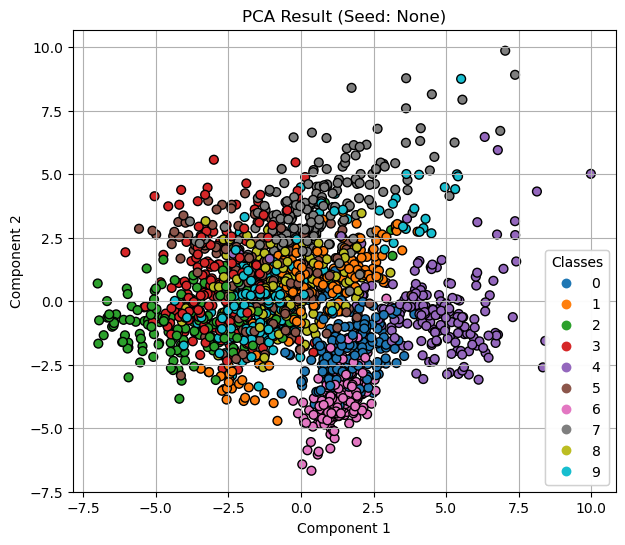

In [9]:
import tkinter as tk
from tkinter import ttk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from minisom import MiniSom
import random


# Initialize the main window
root = tk.Tk()
root.title("Dimensionality Reduction Techniques")

# Frames
control_frame = tk.Frame(root)
control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

plot_frame = tk.Frame(root)
plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

# Method Selection
method_label = tk.Label(control_frame, text="Select Technique:")
method_label.pack()

method_var = tk.StringVar()
method_combobox = ttk.Combobox(control_frame, textvariable=method_var)
method_combobox['values'] = ['PCA', 't-SNE', 'UMAP', 'Isomap', 'SOM', 'Autoencoder', 'Autoencoder + t-SNE']
method_combobox.pack()
method_combobox.current(0)

# Frame for parameters
param_frame = tk.Frame(control_frame)
param_frame.pack(pady=10)

# Dictionary to store parameter entries
param_entries = {}

def create_param(name, default=''):
    """Helper function to create input fields dynamically."""
    label = tk.Label(param_frame, text=name)
    label.pack()
    entry = tk.Entry(param_frame)
    entry.insert(0, default)
    entry.pack()
    param_entries[name] = entry

def update_parameters(event):
    """Update available parameters based on selected method."""
    for widget in param_frame.winfo_children():
        widget.destroy()

    method = method_var.get()
    param_entries.clear()

    if method == 'PCA':
        create_param('n_components', default='2')

    elif method == 't-SNE':
        create_param('n_components', default='2')
        create_param('perplexity', default='30')

    elif method == 'UMAP':
        create_param('n_components', default='2')
        create_param('n_neighbors', default='15')
        create_param('min_dist', default='0.1')

    elif method == 'Isomap':
        create_param('n_components', default='2')
        create_param('n_neighbors', default='5')

    elif method == 'SOM':
        create_param('grid_size', default='10')
        create_param('sigma', default='1.0')
        create_param('learning_rate', default='0.5')

    elif method == 'Autoencoder':
        create_param('encoding_dim', default='2')
        create_param('epochs', default='50')
        create_param('batch_size', default='16')

    elif method == 'Autoencoder + t-SNE':
        create_param('encoding_dim', default='2')
        create_param('epochs', default='50')
        create_param('batch_size', default='16')
        create_param('perplexity', default='30')

method_combobox.bind('<<ComboboxSelected>>', update_parameters)

canvas = None  # To store the plot canvas

def run_method(seed=None):
    global canvas

    method = method_var.get()

    fig, ax = plt.subplots(figsize=(7, 6))

    try:
        if canvas:
            canvas.get_tk_widget().destroy()
    except tk.TclError:
        pass

    try:
        if method == 'PCA':
            n_components = int(param_entries['n_components'].get())
            pca = PCA(n_components=n_components, random_state=seed)
            X_pca = pca.fit_transform(X_scaled)
            plot_data = X_pca[:, :2]

        elif method == 't-SNE':
            n_components = int(param_entries['n_components'].get())
            perplexity = float(param_entries['perplexity'].get())
            tsne = TSNE(n_components=n_components, random_state=seed, perplexity=perplexity)
            plot_data = tsne.fit_transform(X_scaled)

        elif method == 'UMAP':
            n_components = int(param_entries['n_components'].get())
            n_neighbors = int(param_entries['n_neighbors'].get())
            min_dist = float(param_entries['min_dist'].get())
            reducer = umap.UMAP(n_components=n_components, random_state=seed,
                                n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean')
            plot_data = reducer.fit_transform(X_scaled)

        elif method == 'Isomap':
            n_components = int(param_entries['n_components'].get())
            n_neighbors = int(param_entries['n_neighbors'].get())
            isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
            plot_data = isomap.fit_transform(X_scaled)

        elif method == 'SOM':
            grid_size = int(param_entries['grid_size'].get())
            sigma = float(param_entries['sigma'].get())
            learning_rate = float(param_entries['learning_rate'].get())
            som = MiniSom(x=grid_size, y=grid_size, input_len=X_scaled.shape[1],
                          sigma=sigma, learning_rate=learning_rate, random_seed=seed)
            som.train_random(X_scaled, 100)
            plot_data = np.array([som.winner(x) for x in X_scaled])

        elif method == 'Autoencoder':
            encoding_dim = int(param_entries['encoding_dim'].get())
            epochs = int(param_entries['epochs'].get())
            batch_size = int(param_entries['batch_size'].get())
            input_dim = X_scaled.shape[1]
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(10, activation='relu')(input_layer)
            encoded = Dense(encoding_dim, activation='linear')(encoded)
            decoded = Dense(10, activation='relu')(encoded)
            decoded = Dense(input_dim, activation='linear')(decoded)
            autoencoder = Model(input_layer, decoded)
            encoder = Model(input_layer, encoded)
            autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
            autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
            plot_data = encoder.predict(X_scaled)

        elif method == 'Autoencoder + t-SNE':
            encoding_dim = int(param_entries['encoding_dim'].get())
            epochs = int(param_entries['epochs'].get())
            batch_size = int(param_entries['batch_size'].get())
            perplexity = float(param_entries['perplexity'].get())

            # Autoencoder
            input_dim = X_scaled.shape[1]
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(10, activation='relu')(input_layer)
            encoded = Dense(encoding_dim, activation='linear')(encoded)
            decoded = Dense(10, activation='relu')(encoded)
            decoded = Dense(input_dim, activation='linear')(decoded)
            autoencoder = Model(input_layer, decoded)
            encoder = Model(input_layer, encoded)
            autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
            autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

            # Apply t-SNE to Autoencoder's encoded output
            encoded_data = encoder.predict(X_scaled)
            tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity)
            plot_data = tsne.fit_transform(encoded_data)

        # Plotting
        scatter = ax.scatter(
            plot_data[:, 0],
            plot_data[:, 1],
            c=y,
            cmap='tab10',  # Use discrete colors for classification
            edgecolor='k',
            s=40
        )
        ax.set_title(f"{method} Result (Seed: {seed})")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.grid(True)
        
        # Add legend for class labels
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes", loc="best")
        ax.add_artist(legend1)
        
        # Embed the plot in the GUI
        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


    except Exception as e:
        print(f"Error: {e}")

# Run button for one time
run_button = tk.Button(control_frame, text="Run", command=run_method)
run_button.pack(pady=20)

# Button for running 30 repetitions
def run_30_reps():
    seeds = [random.randint(0, 10000) for _ in range(30)]  # List of 30 seeds
    for seed in seeds:
        run_method(seed=seed)  # Run the selected technique with a new seed for each repetition

    # Save seeds to a file for later reference
    with open("seeds_used.txt", "w") as f:
        for seed in seeds:
            f.write(f"{seed}\n")
    print(f"Seeds saved to 'seeds_used.txt'.")

run_30_button = tk.Button(control_frame, text="Run 30 Repetitions", command=run_30_reps)
run_30_button.pack(pady=10)

# Initialize with parameters of first method
update_parameters(None)

root.mainloop()
